# Combining Runkeeper GPX data into single dataset

Runkeeper is an application that allows user to log information about their various physical activities. This includes GPS tracking throughout the duration of the activity. For me, this typically means cycling. Although Runkeeper does not expose an API to access your data, [you can export it in bulk from within your user settings.](https://runkeeper.com/exportData)

That export will provide you with a ot of data about your activity, however it requires some processing to make more useful. This is namely because each activity is exported as an individual GPX. Especially as GIS user, this is a bit inconvenient as GIS workflow and indeed most general data workflows assume all your data are compiled into a single table (or set of related tables).

The purpose of this notebook is to walk through how one might take a directory of GPX data downloaded from Runkeeper and set about combining tracks and track points into combined datasets, respectively.

## Libraries

In [1]:
%matplotlib inline
import os
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import pandas as pd

## Examining the data

Before iterating over every GPX file, let's take a look at what is in the files we want to do any transformations or data cleaning. In this case, we know we only want to look at the *tracks* and *track_points* layers as they are the only layers for which data were collected.

In [2]:
test_gpx = ('./data/2018-01-02-075021.gpx')

### tracks

In [3]:
track_gdf = gpd.read_file(test_gpx, layer='tracks')
track_gdf.head()

name   cmt  desc   src link1_href link1_text link1_type  \
0  Cycling 1/2/18 7:50 am  None  None  None       None       None       None   

  link2_href link2_text link2_type number  type  \
0       None       None       None   None  None   

                                            geometry  
0  (LINESTRING (-78.68072100000001 35.796641, -78...

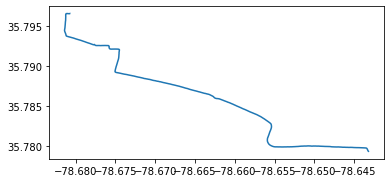

In [4]:
track_gdf['geometry'].plot()

It looks like we don't get much with the track. Just a single line feature and some info describing typ and time of the ride in the `name` field. Perhaps we can make this more useful then!

In [5]:
track_gdf2 = track_gdf[['name', 'geometry']].copy()
track_gdf2.head()

name                                           geometry
0  Cycling 1/2/18 7:50 am  (LINESTRING (-78.68072100000001 35.796641, -78...

There's a lot of info encoded in the *name* field. Let's finish up exploring how to clean this up by splitting *name* into two separate fields

- type: This will represent the type of activity. For the most part this should be **Cycling**, but there are several other types of activities that Runkeeper logs.
- datetime: This will represent a datetime datatype for the date and time info stored as string values in *name*

In [6]:
for idx, row in track_gdf2.iterrows():
    split = row['name'].split()
    track_gdf2.loc[idx, 'type'] = split[0]
    track_gdf2.loc[idx, 'datetime'] = datetime.strptime(' '.join([split[1], split[2], split[3].upper()]), '%m/%d/%y %I:%M %p')
track_gdf2.head()

name                                           geometry  \
0  Cycling 1/2/18 7:50 am  (LINESTRING (-78.68072100000001 35.796641, -78...   

      type            datetime  
0  Cycling 2018-01-02 07:50:00

In [7]:
track_gdf2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
name        1 non-null object
geometry    1 non-null object
type        1 non-null object
datetime    1 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 112.0+ bytes


### track_points

The `track_points` layer in each dataset is a log of information collected at regular intervals throughout the ride. These points represent the vertices in the `track` layer, but there is more information encoded for each point. Let's explore what's in this layer and see if there's further processing to be done to it.

In [8]:
track_points_gdf = gpd.read_file(test_gpx, layer='track_points')
track_points_gdf.head()

track_fid  track_seg_id  track_seg_point_id    ele                 time  \
0          0             0                   0  128.0  2018-01-02T12:50:21   
1          0             0                   1  128.0  2018-01-02T12:51:16   
2          0             1                   0  129.3  2018-01-02T12:51:28   
3          0             1                   1  129.4  2018-01-02T12:51:41   
4          0             1                   2  129.5  2018-01-02T12:51:44   

  magvar geoidheight  name   cmt  desc  ...   sym  type   fix   sat  hdop  \
0   None        None  None  None  None  ...  None  None  None  None  None   
1   None        None  None  None  None  ...  None  None  None  None  None   
2   None        None  None  None  None  ...  None  None  None  None  None   
3   None        None  None  None  None  ...  None  None  None  None  None   
4   None        None  None  None  None  ...  None  None  None  None  None   

   vdop  pdop ageofdgpsdata dgpsid                              geometry  
0  None  None          None   None  POINT (-78.68072100000001 35.796641)  
1  None  None          None   None           POINT (-78.680666 35.79662)  
2  None  None          None   None           POINT (-78.680666 35.79662)  
3  None  None          None   None          POINT (-78.680819 35.796599)  
4  None  None          None   None          POINT (-78.680938 35.796603)  

[5 rows x 27 columns]

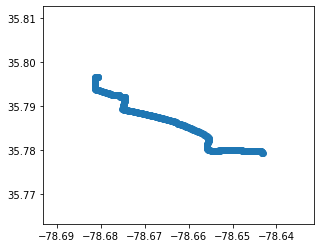

In [9]:
track_points_gdf.plot()

In [10]:
track_points_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 27 columns):
track_fid             352 non-null int64
track_seg_id          352 non-null int64
track_seg_point_id    352 non-null int64
ele                   352 non-null float64
time                  352 non-null object
magvar                0 non-null object
geoidheight           0 non-null object
name                  0 non-null object
cmt                   0 non-null object
desc                  0 non-null object
src                   0 non-null object
link1_href            0 non-null object
link1_text            0 non-null object
link1_type            0 non-null object
link2_href            0 non-null object
link2_text            0 non-null object
link2_type            0 non-null object
sym                   0 non-null object
type                  0 non-null object
fix                   0 non-null object
sat                   0 non-null object
hdop                  0 non-null object

It appears that even though there are several more columns in the `track_points` layer, Runkeeper only has values for some. Let's reduce this down to something a bit more manageable to look at.

In [11]:
track_points_gdf2 = track_points_gdf[['track_seg_point_id', 'ele', 'time', 'geometry']].copy()
track_points_gdf2.head()

track_seg_point_id    ele                 time  \
0                   0  128.0  2018-01-02T12:50:21   
1                   1  128.0  2018-01-02T12:51:16   
2                   0  129.3  2018-01-02T12:51:28   
3                   1  129.4  2018-01-02T12:51:41   
4                   2  129.5  2018-01-02T12:51:44   

                               geometry  
0  POINT (-78.68072100000001 35.796641)  
1           POINT (-78.680666 35.79662)  
2           POINT (-78.680666 35.79662)  
3          POINT (-78.680819 35.796599)  
4          POINT (-78.680938 35.796603)

This is looking better, although it'd be nice if *time* were a datetime data type.

In [12]:
track_points_gdf2['time'] = track_points_gdf2.apply(lambda row: datetime.strptime(row['time'], '%Y-%m-%dT%H:%M:%S'), axis=1)
track_points_gdf2.head()

track_seg_point_id    ele                time  \
0                   0  128.0 2018-01-02 12:50:21   
1                   1  128.0 2018-01-02 12:51:16   
2                   0  129.3 2018-01-02 12:51:28   
3                   1  129.4 2018-01-02 12:51:41   
4                   2  129.5 2018-01-02 12:51:44   

                               geometry  
0  POINT (-78.68072100000001 35.796641)  
1           POINT (-78.680666 35.79662)  
2           POINT (-78.680666 35.79662)  
3          POINT (-78.680819 35.796599)  
4          POINT (-78.680938 35.796603)

## Processing the directory

Now that we've worked out what we want to do to the `tracks` and `track_points` layers on a single example, now we can apply the same logic to iterrate through a directory of GPX files.

### Get a list of paths to GPX files

To iterrate through the `data` directory, we'll generate a Python list of paths to all GPX files in that directory.

In [13]:
gpx_files = [file for file in glob.glob('data/*.gpx')]
print(f'First 5 GPX files in data directory:\n{gpx_files[:5]}')

First 5 GPX files in data directory:
['data\\2018-01-02-075021.gpx', 'data\\2018-01-02-161450.gpx', 'data\\2018-01-03-075009.gpx', 'data\\2018-01-03-160600.gpx', 'data\\2018-01-05-073517.gpx']


### Create a place to store processing results for each GPX file

In [14]:
processed_gps_data = {
    "tracks": [],
    "track_points": []
}

### Iterrate through directory and push results to appropriate list in `processed_gps_data`

In [15]:
%%time
print(f'Processing tracks and track_points for {len(gpx_files)} GPX datasets...')
for g in gpx_files:
    # tracks
    try:
        g_track_gdf = gpd.read_file(g, layer='tracks')
        g_track_reduced_gdf = g_track_gdf[['name', 'geometry']].copy()
        for idx, row in g_track_reduced_gdf.iterrows():
            split = row['name'].split()
            g_track_reduced_gdf.loc[idx, 'type'] = split[0]
            g_track_reduced_gdf.loc[idx, 'time'] = str(datetime.strptime(' '.join([split[1], split[2], split[3].upper()]), '%m/%d/%y %I:%M %p'))
        processed_gps_data["tracks"].append(g_track_reduced_gdf)
    except:
        print(f'Something weird with tracks for {g}')
        pass
                     
    #track_points
    try:
        g_track_points_gdf = gpd.read_file(g, layer='track_points')
        g_track_points_gdf = g_track_points_gdf[['track_seg_point_id', 'ele', 'time', 'geometry']].copy()
        g_track_points_gdf['time'] = g_track_points_gdf.apply(lambda row: str(datetime.strptime(row['time'], '%Y-%m-%dT%H:%M:%S')), axis=1)
        processed_gps_data["track_points"].append(g_track_points_gdf)
    except:
        print(f'Something weird with track_points for {g}')
        pass

Processing tracks and track_points for 471 GPX datasets...
Wall time: 33.6 s


### Create GeoDataFrames of combined tracks and track_points data

In [16]:
%time
tracks_all_gdf = gpd.GeoDataFrame(pd.concat(processed_gps_data["tracks"], ignore_index = True), crs = {'init':'epsg:4326'})
track_points_all_gdf = gpd.GeoDataFrame(pd.concat(processed_gps_data["track_points"], ignore_index = True), crs = {'init':'epsg:4326'})

Wall time: 0 ns


In [17]:
track_points_all_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 141270 entries, 0 to 141269
Data columns (total 4 columns):
track_seg_point_id    141270 non-null int64
ele                   141270 non-null float64
time                  141270 non-null object
geometry              141270 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 4.3+ MB


## View results

In [18]:
import pandas_bokeh
pandas_bokeh.output_notebook()

Loading BokehJS ...

### Result: Tracks

In [19]:
tracks_all_gdf.plot_bokeh(
    figsize=(900, 600),
    legend="Tracks",
    show_colorbar=False,
    tile_provider_url="https://a.basemaps.cartocdn.com/dark_all/{Z}/{X}/{Y}{R}.png",
    color='#18FFFF',
    alpha=0.05
)

Figure(id='1002', ...)

We'll stop here with the visualizations as the number of track points makes visualization with Bokeh a bit sluggish. Instead we can export both the tracks and track points to GeoJSON for use in other applications like QGIS!

## Export Data to GeoJSON

In [20]:
# Export tracks
tracks_all_gdf.to_file('tracks.geojson', driver="GeoJSON")
# Export track points
track_points_all_gdf.to_file('track_points.geojson', driver="GeoJSON")